# CellRank pipeline with Experimental time Kernel

In [2]:
import sys
#!pip install -q git+https://github.com/theislab/cellrank
#!pip install moscot
import cellrank as cr
from cellrank.kernels import RealTimeKernel
from moscot.problems.time import TemporalProblem
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

In [4]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

### Initialization 

In [5]:
adata = sc.read("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Matrix/p2.h5ad")
adata

AnnData object with n_obs × n_vars = 54606 × 18723
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'timepoint', 'doublet_finder', 'percent.mt', 'qc_pass', 'RNA_snn_res.0.1', 'seurat_clusters', 'RNA.weight', 'ADT.weight', 'wsnn_res.0.1', 'SingleR', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'manual_annotation', 'final_annot', 'annotation', 'Annotation'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
    uns: 'neighbors'
    obsm: 'X_adt.umap', 'X_integrated_dr', 'X_pca', 'X_ref.umap', 'X_tsne', 'X_umap', 'X_wnn.umap'
    varm: 'PCs'
    obsp: 'distances'

In [6]:
print(f"This detected {adata.var['vf_vst_counts_variable'].sum()} highly variable genes. ")

This detected 2000 highly variable genes. 


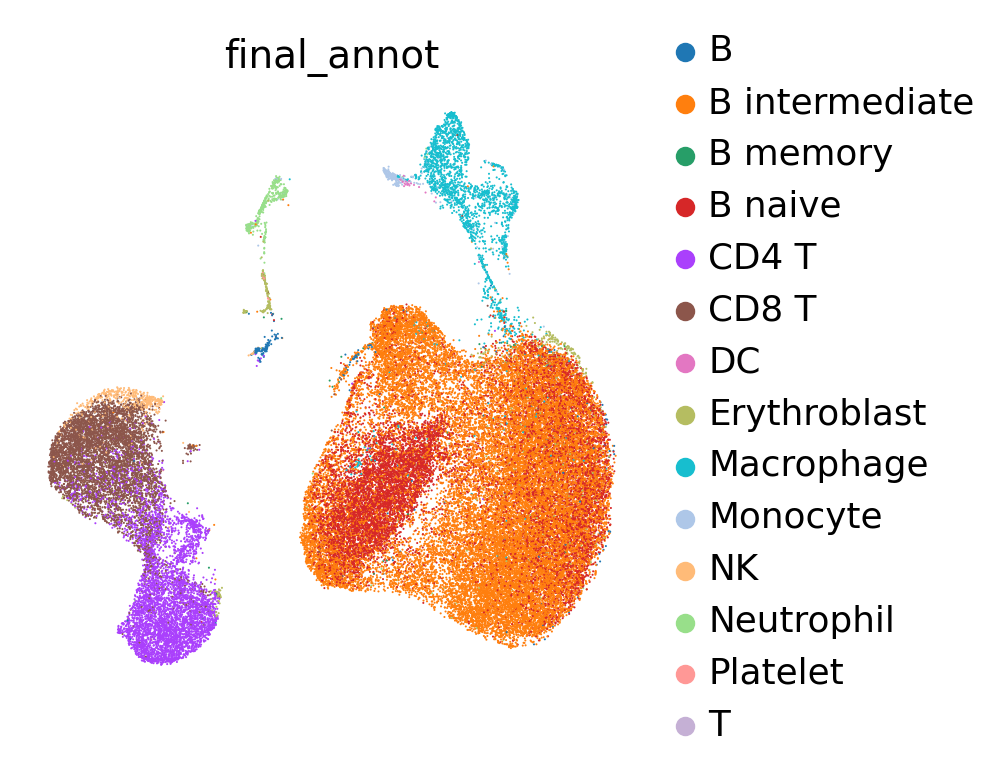

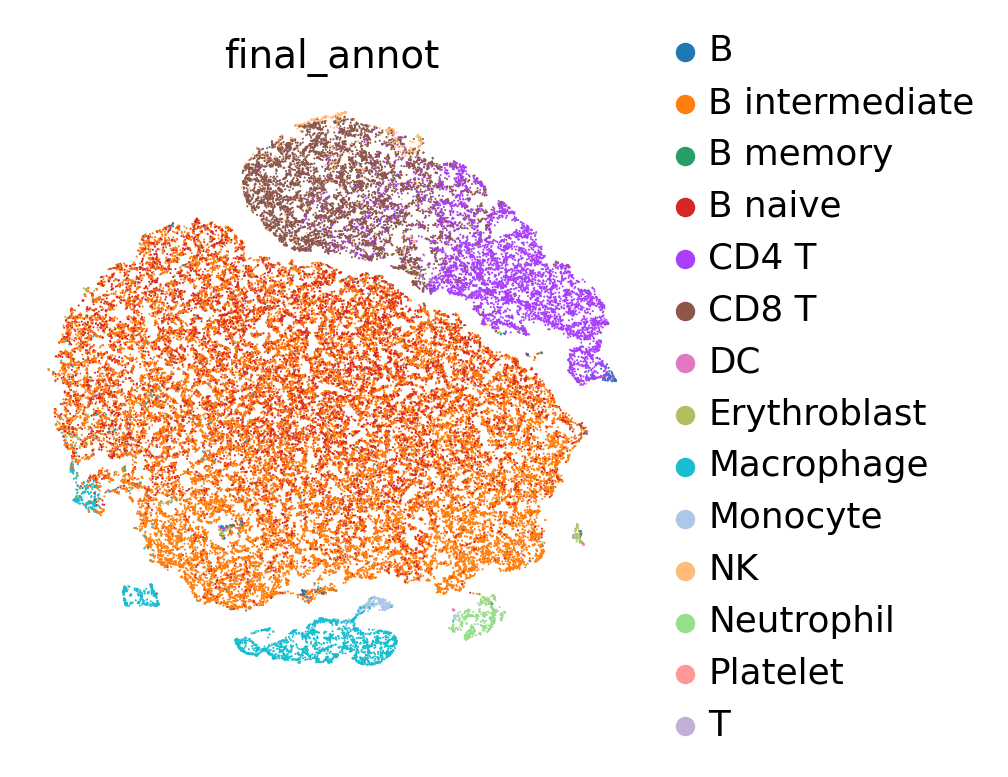

In [7]:
sc.pl.embedding(adata, basis="X_umap", color=["final_annot"])
sc.pl.embedding(adata, basis="X_tsne", color=["final_annot"])

In [8]:
# Extraire le nombre après 'D' et convertir en float
adata.obs["day_numerical"] = adata.obs["timepoint"].str.extract('D(\d+)').astype(float)

# Garder category pour le kernel (ordre alphabétique préservé si D1<D11<D14...)
adata.obs["timepoint"] = adata.obs["timepoint"].astype("category")

print(adata.obs[["timepoint", "day_numerical"]].head())
print(adata.obs[["timepoint", "day_numerical"]].tail())

                      timepoint  day_numerical
D1_AAACCCAAGTCCCGAC-1        D1            1.0
D1_AAACCCACACGCTGTG-1        D1            1.0
D1_AAACCCACATAGCACT-1        D1            1.0
D1_AAACCCACATGGCCCA-1        D1            1.0
D1_AAACCCAGTCTTTCTA-1        D1            1.0
                       timepoint  day_numerical
D14_TTTGTTGTCAATCTTC-1       D14           14.0
D14_TTTGTTGTCAGGACAG-1       D14           14.0
D14_TTTGTTGTCATTATCC-1       D14           14.0
D14_TTTGTTGTCCAGTACA-1       D14           14.0
D14_TTTGTTGTCTCTAGGA-1       D14           14.0


In [9]:
cell_types_to_keep = [ 'B intermediate', 'B memory', 'B naive', 'Bridge', 'Monocyte', 'Macrophage',]
adata = adata[adata.obs['Annotation'].isin(cell_types_to_keep)].copy()

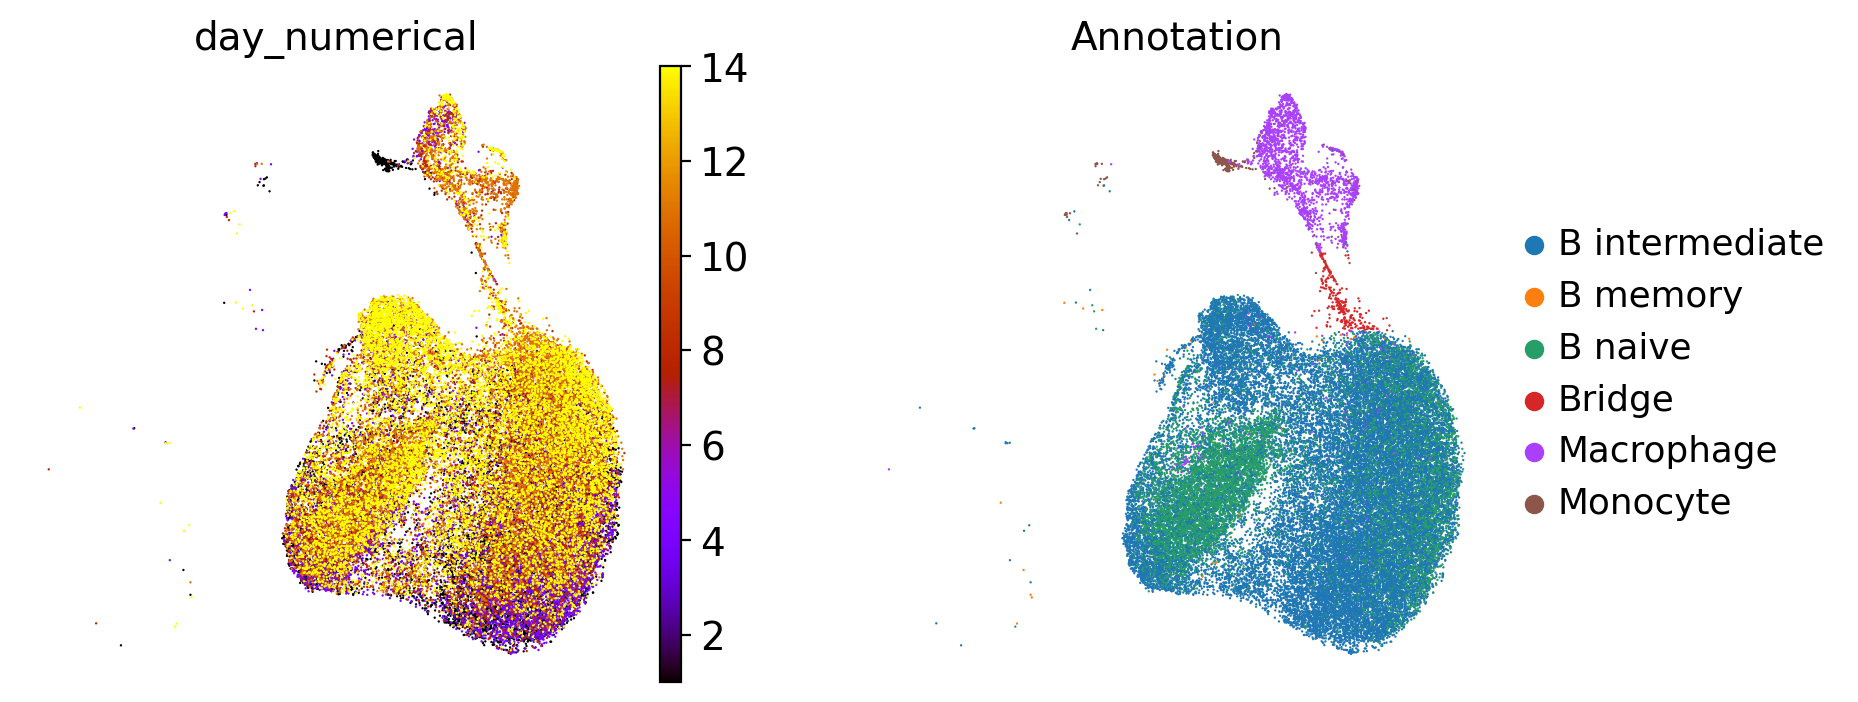

In [10]:
sc.pl.embedding(
    adata,
    basis= "X_umap",
    color=["day_numerical", "Annotation"],
    color_map="gnuplot",
)

## Reconstruct differentiation trajectories across time points

In [11]:
tp = TemporalProblem(adata)

In [12]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human"
)

computing score 'proliferation'
    finished (0:00:00)
computing score 'apoptosis'
    finished (0:00:00)


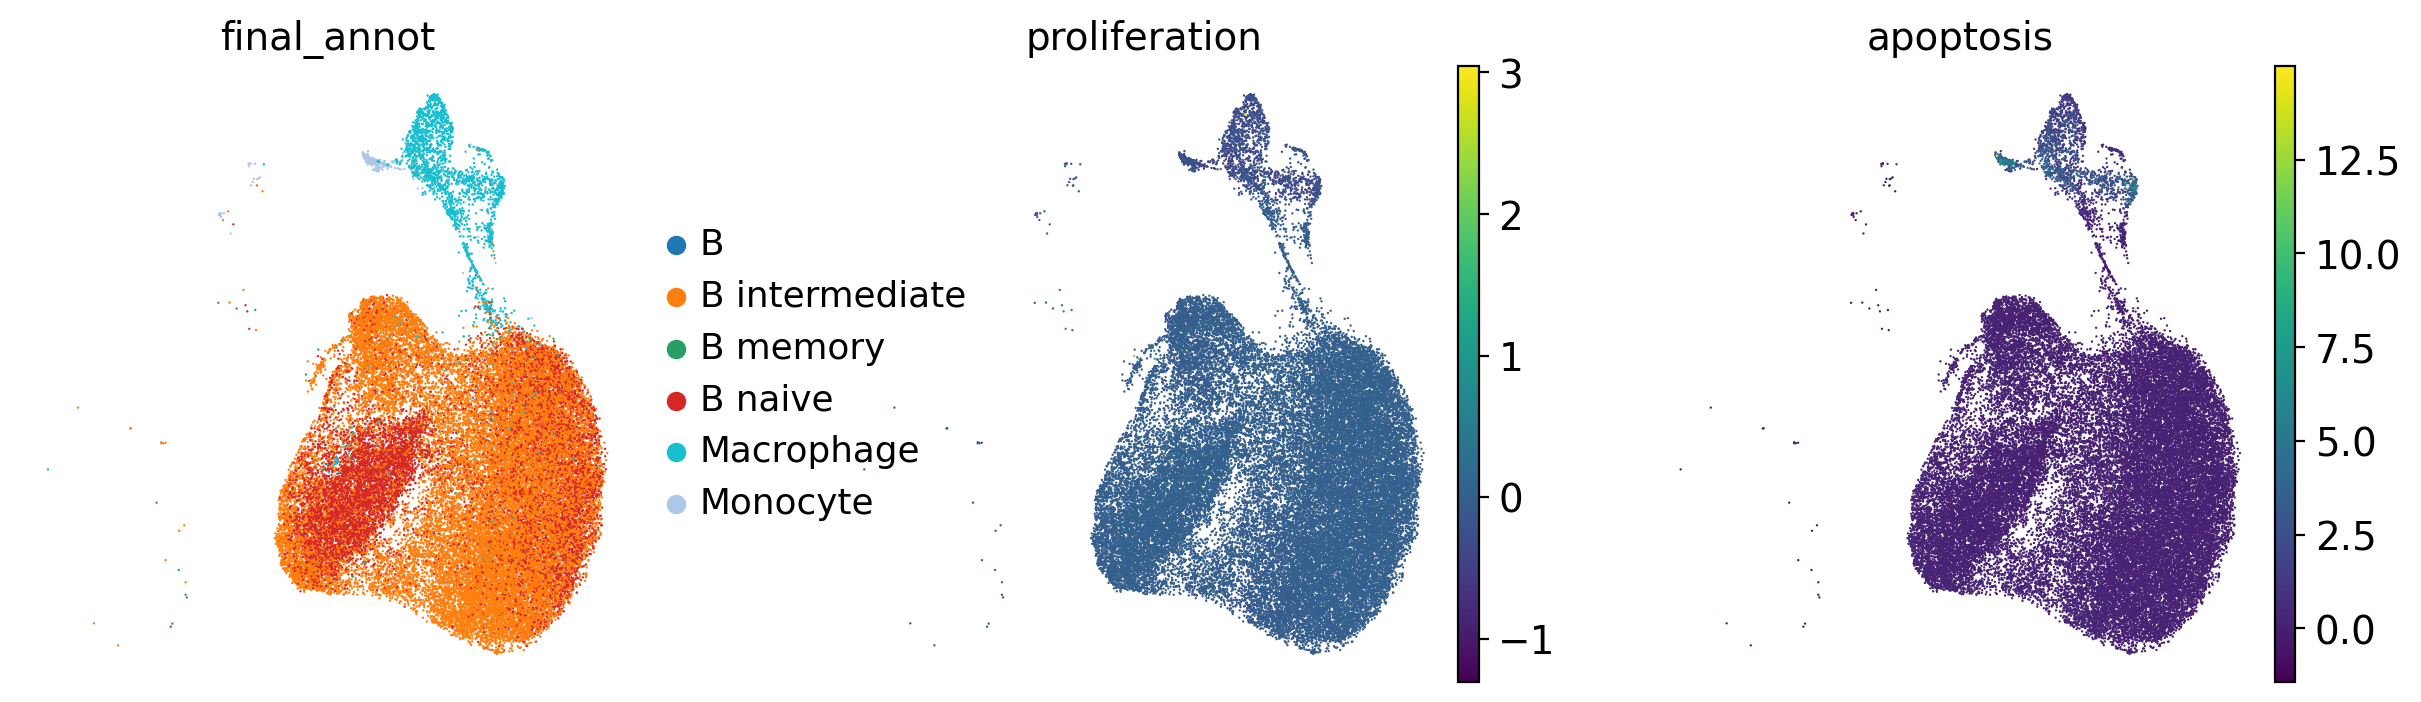

In [13]:
sc.pl.embedding(
    adata, basis="X_umap", color=["final_annot", "proliferation", "apoptosis"]
)

In [14]:
tp = tp.prepare(time_key="day_numerical")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:07)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:07)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:08)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:06)


In [15]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `4` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(6804, 8047)].                                  


INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(8047, 8398)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(8398, 11056)].                                 
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(7696, 6804)].                                  


### Compute RealTimeKernel

In [16]:
tmk = RealTimeKernel.from_moscot(tp)

In [17]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

  0%|          | 0/4 [00:00<?, ?time pair/s]

Using automatic `threshold=4.958610696155786e-19`


RealTimeKernel[n=42001, threshold='auto', self_transitions='all']

Simulating `100` random walks of maximum length `500`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:10)
Plotting random walks


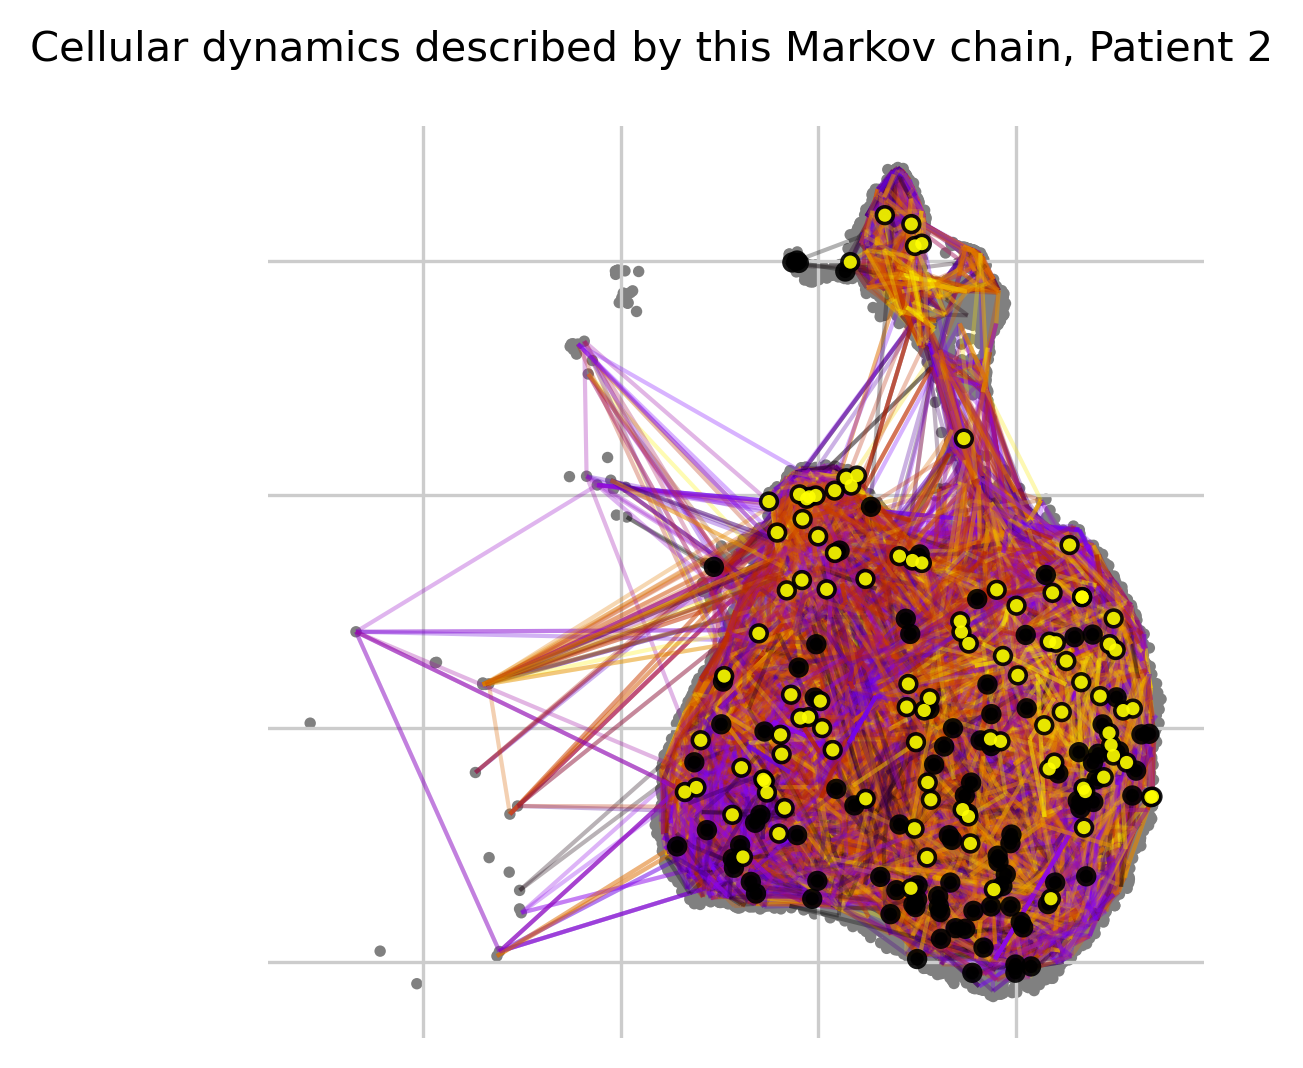

In [18]:
tmk.plot_random_walks(
    max_iter=500,
    start_ixs={"day_numerical": 1.0},
    basis="X_umap",
    seed=0,
    dpi=150,
    size=30,
)
plt.suptitle("Cellular dynamics described by this Markov chain, Patient 2", fontsize=10, y=0.99)
plt.savefig("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/markov_p2.png", dpi=300, bbox_inches='tight')

Computing flow from `Bridge` into `3` cluster(s) in `4` time points
Plotting flow from `Bridge` into `3` cluster(s) in `4` time points


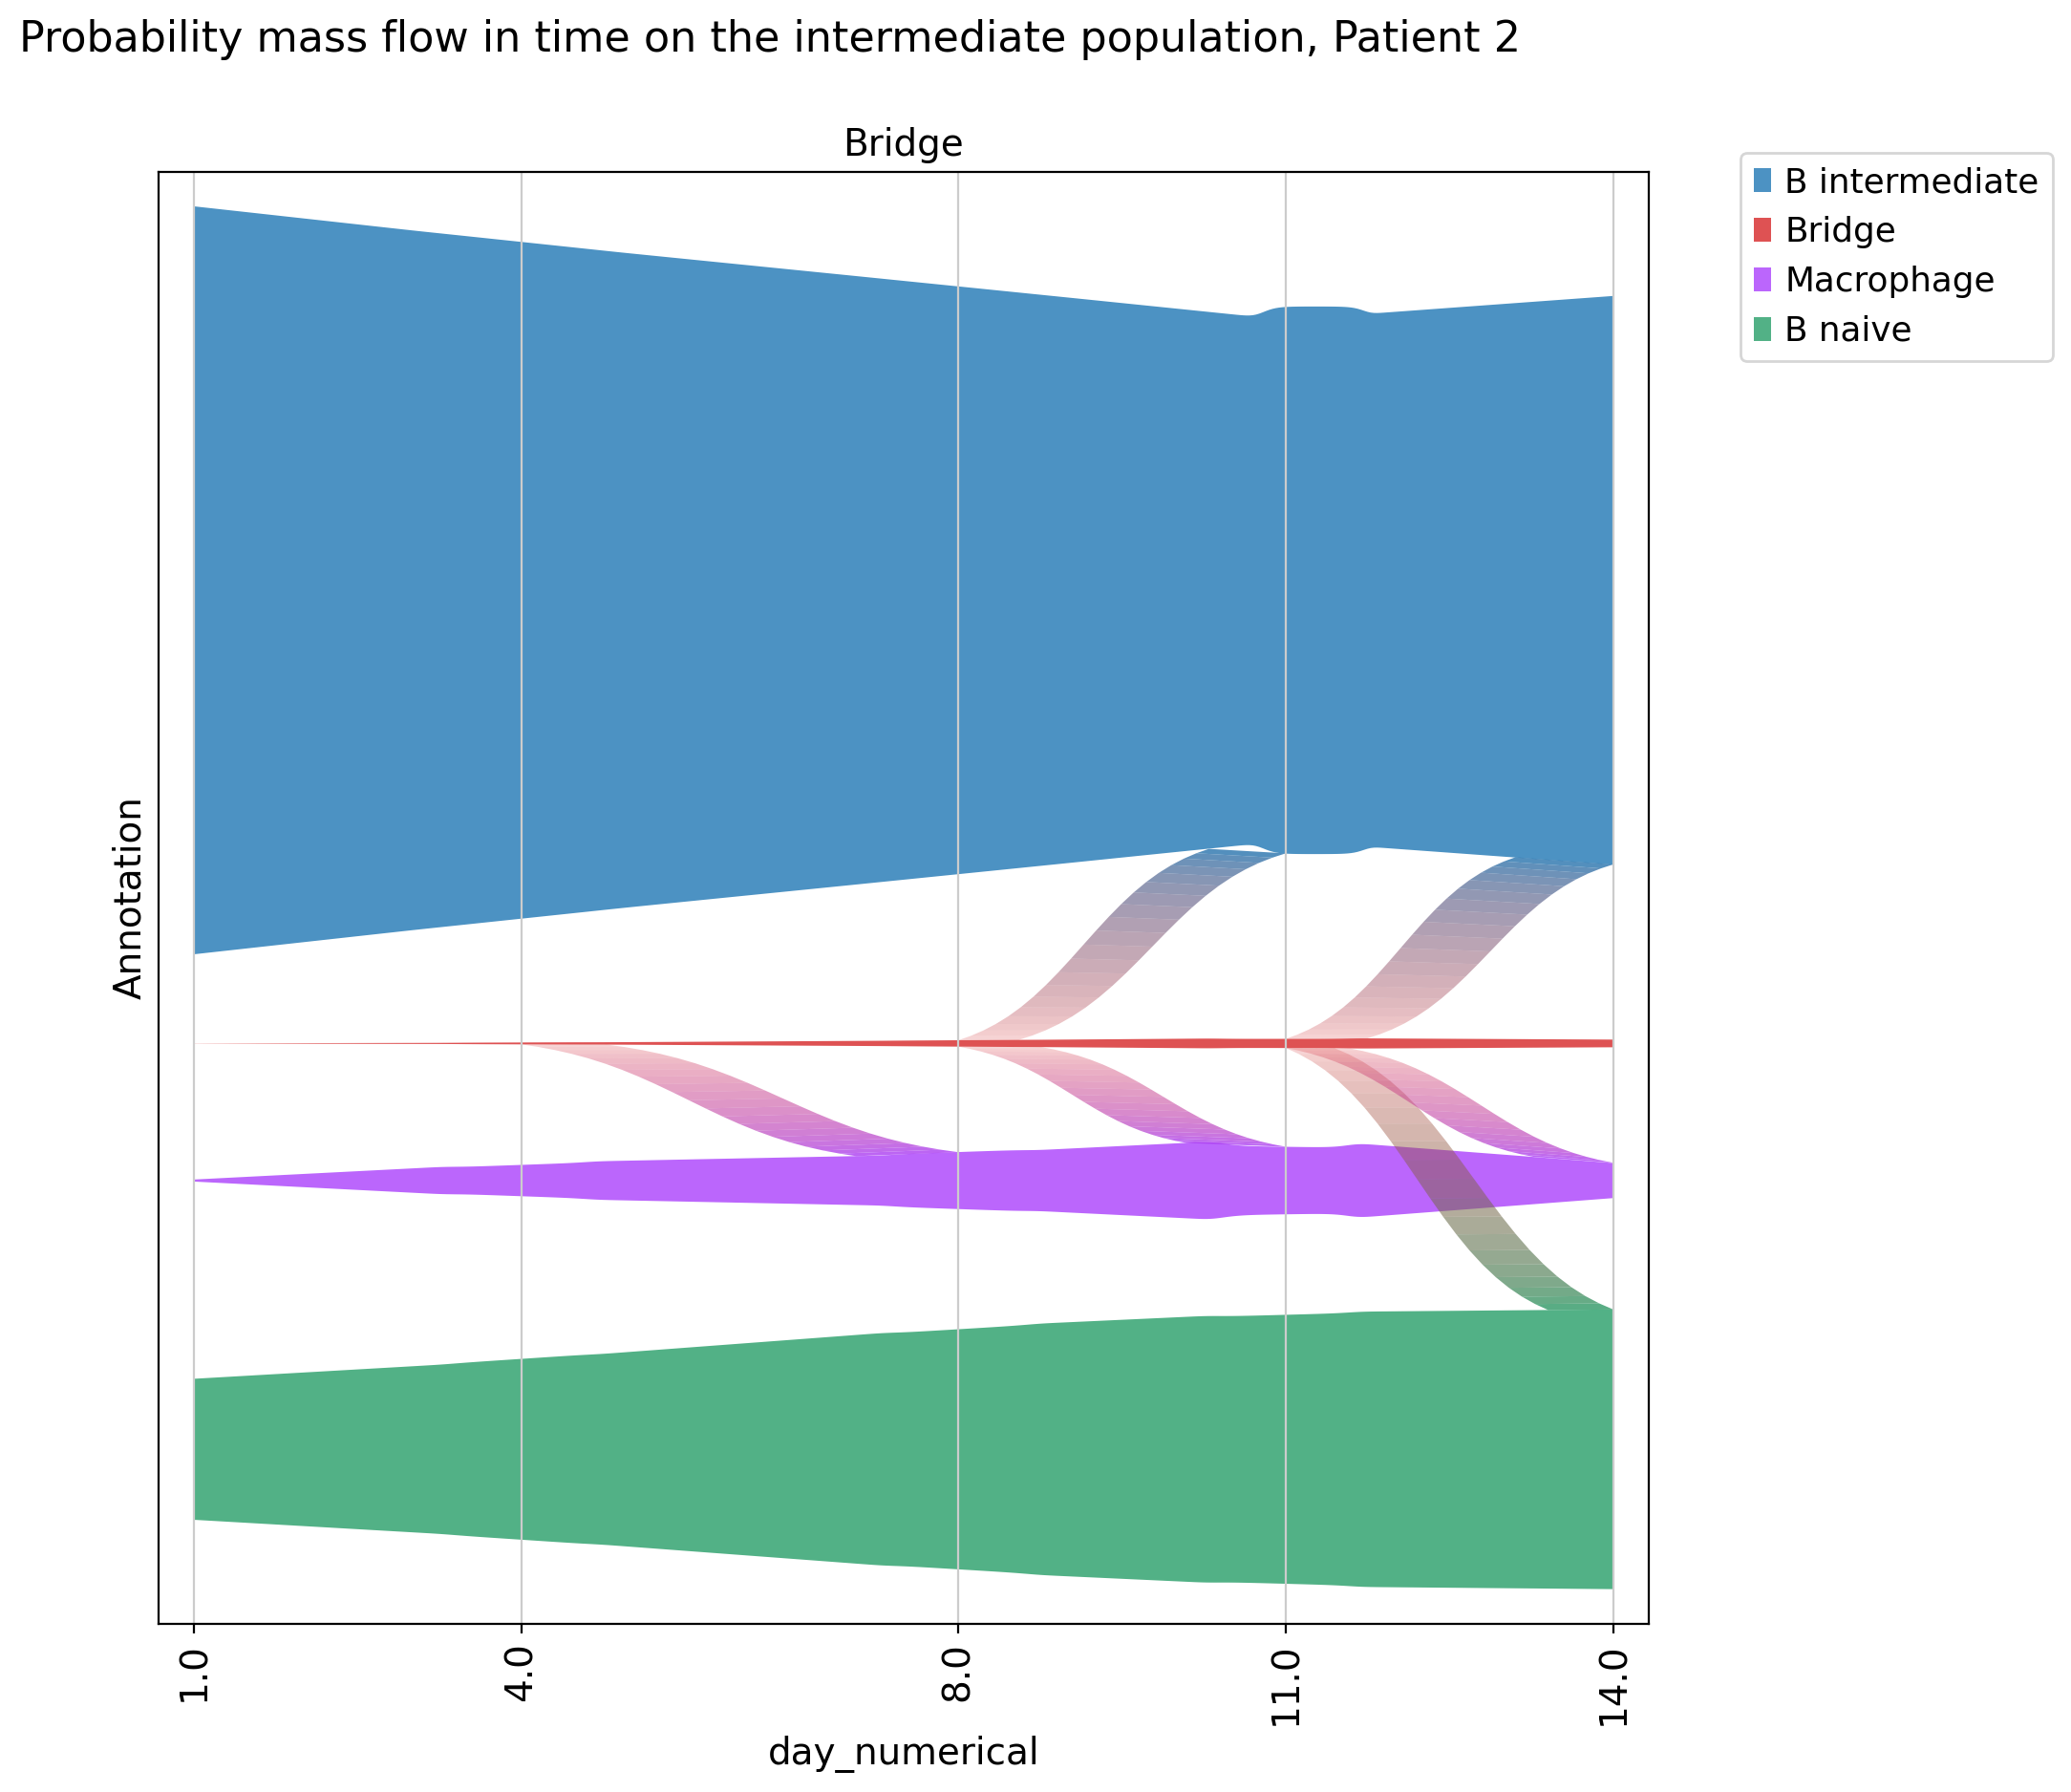

In [19]:
ax = tmk.plot_single_flow(
    cluster_key="Annotation",
    time_key="day_numerical",
    cluster="Bridge",
    min_flow=0.1,
    xticks_step_size=1,
    show=False,
    figsize=[10,10],
    clusters=["Macrophage", "Bridge", "B naive", "B intermediate"],
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.suptitle("Probability mass flow in time on the intermediate population, Patient 2", fontsize=16, y=0.99)
plt.savefig("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/prob_flow_p2.png", dpi=300, bbox_inches='tight')

## Identify initial and terminal states : Initialize an estimator

In [20]:
g = cr.estimators.GPCCA(tmk)
print(g)

GPCCA[kernel=RealTimeKernel[n=42001], initial_states=None, terminal_states=None]


Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Calculating minChi criterion in interval `[4, 12]`
Computing `4` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


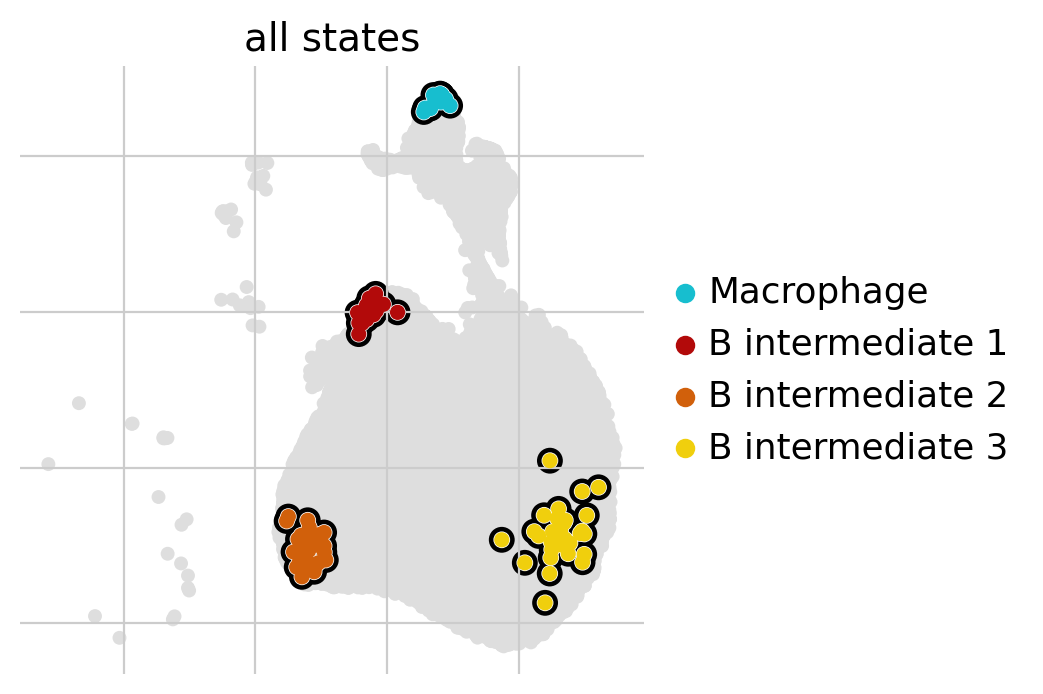

In [22]:
g.fit(cluster_key="final_annot", n_states=[4, 12])
g.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100)

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


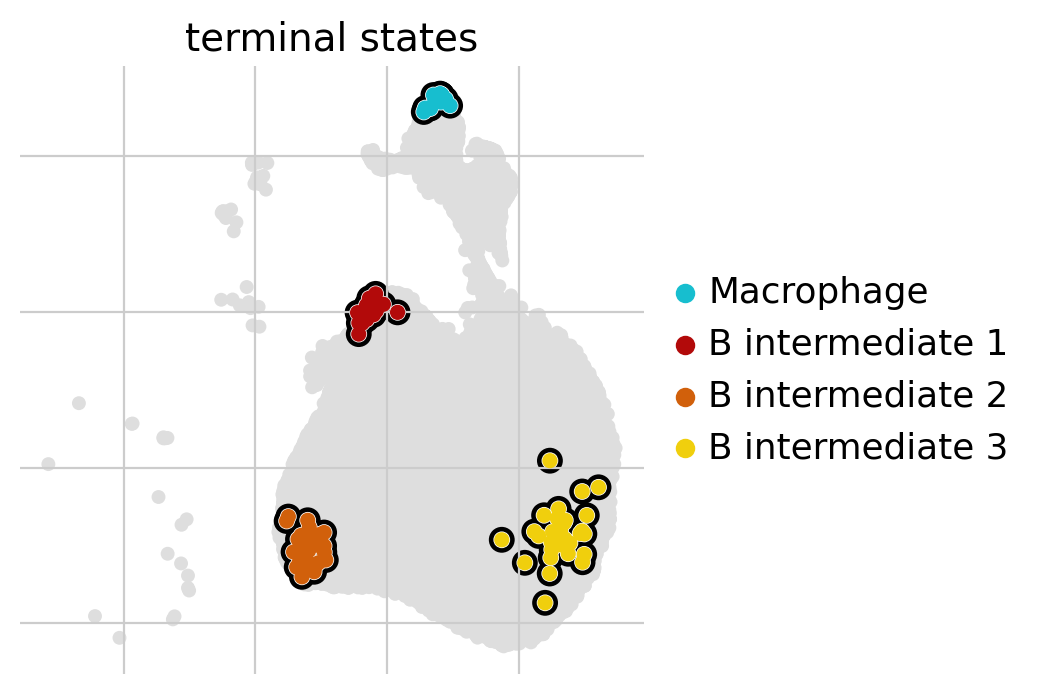

In [23]:
g.predict_terminal_states()
g.plot_macrostates(which="terminal", legend_loc="right", s=100)

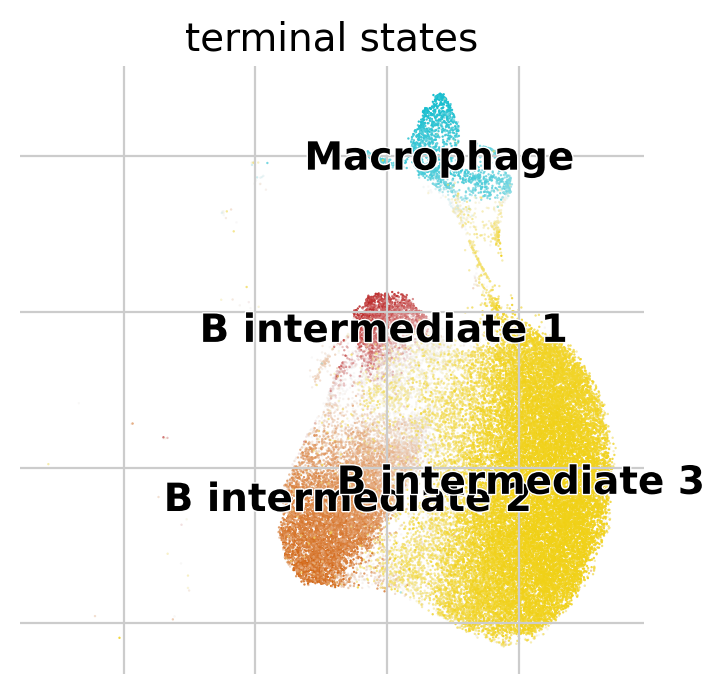

In [24]:
g.plot_macrostates(which="terminal", discrete=False)

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


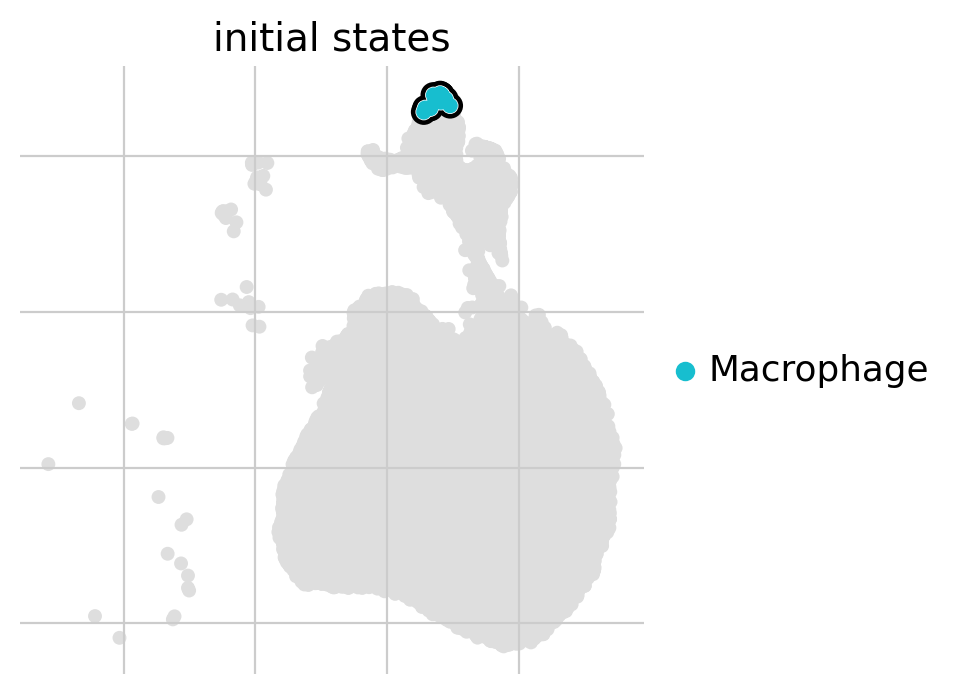

In [27]:
g.predict_initial_states(allow_overlap=True)
g.plot_macrostates(which="initial", legend_loc="right", s=100)

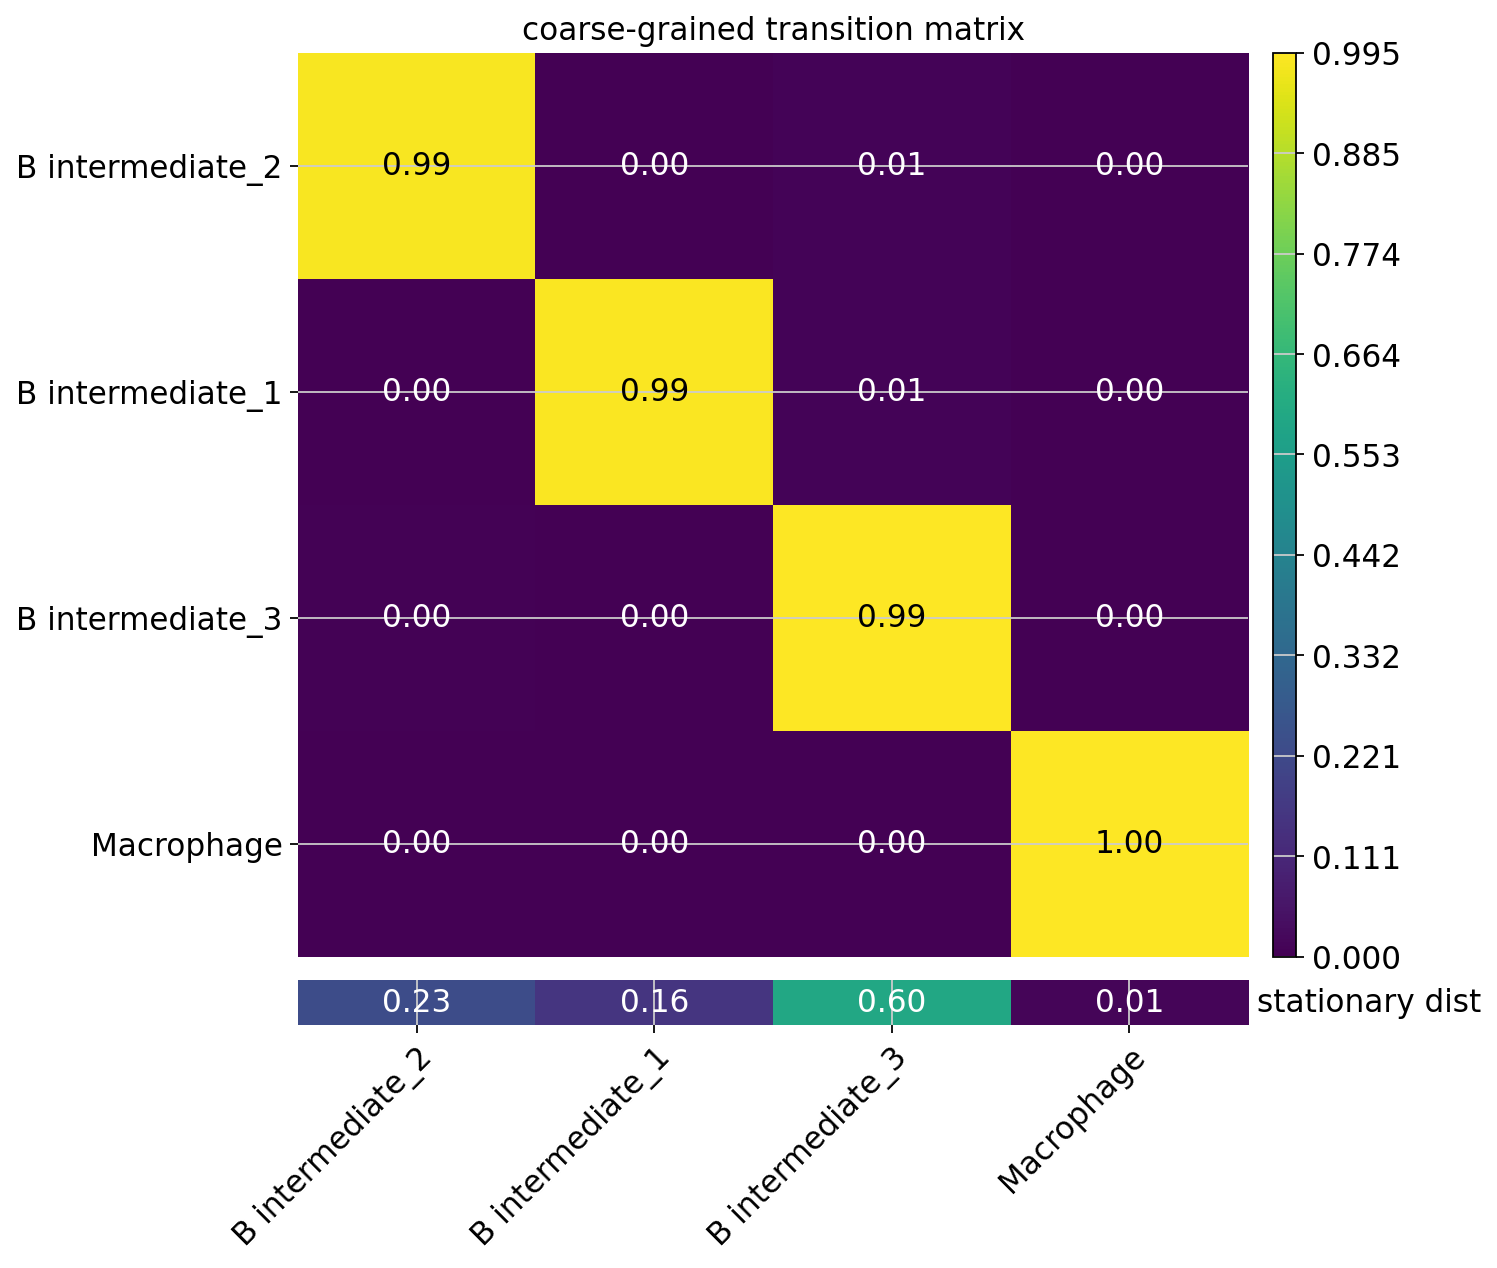

In [28]:
g.plot_coarse_T()

Advanced usage

In [30]:
g2 = cr.estimators.GPCCA(tmk)
print(g2)

GPCCA[kernel=RealTimeKernel[n=42001], initial_states=None, terminal_states=None]


Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


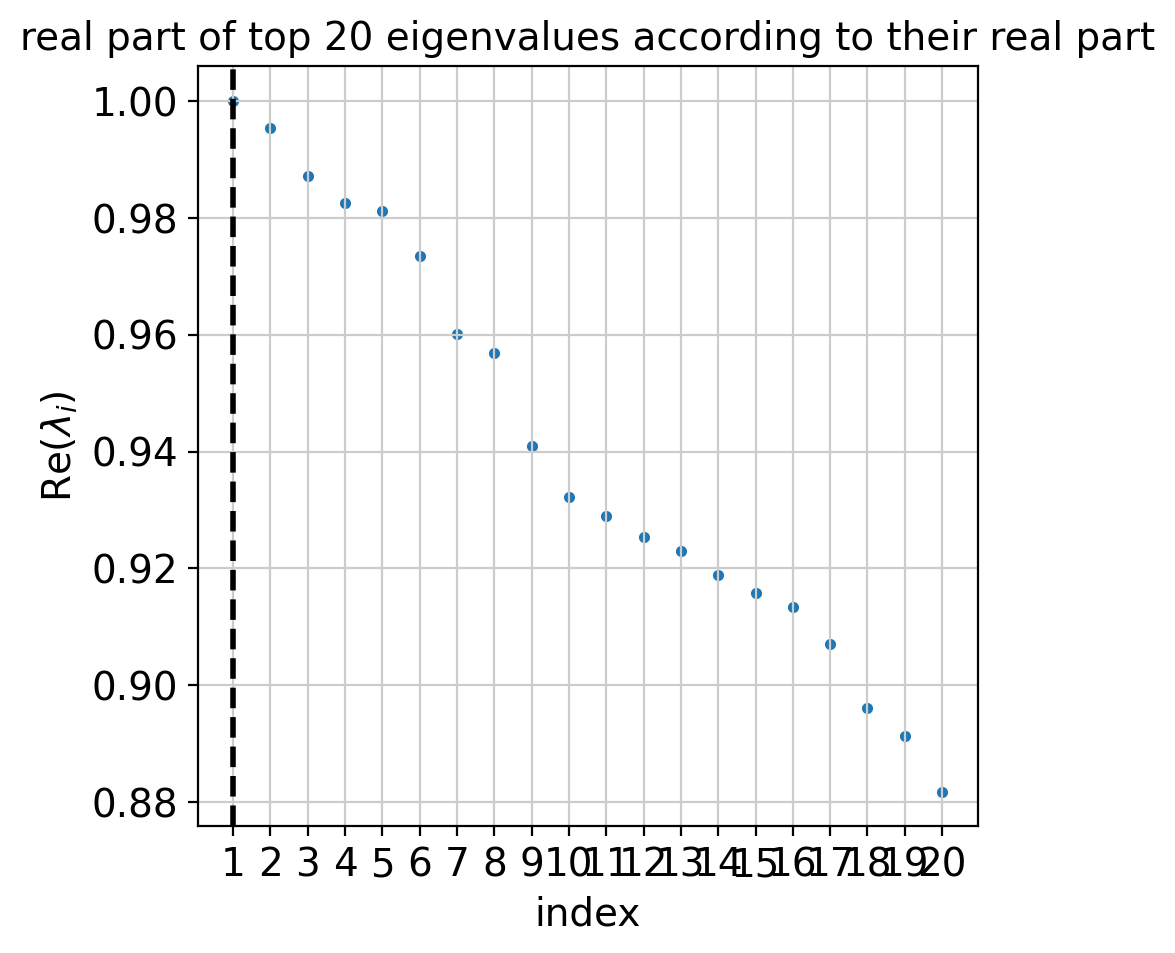

In [31]:
g2.compute_schur()
g2.plot_spectrum(real_only=True)

Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:07)


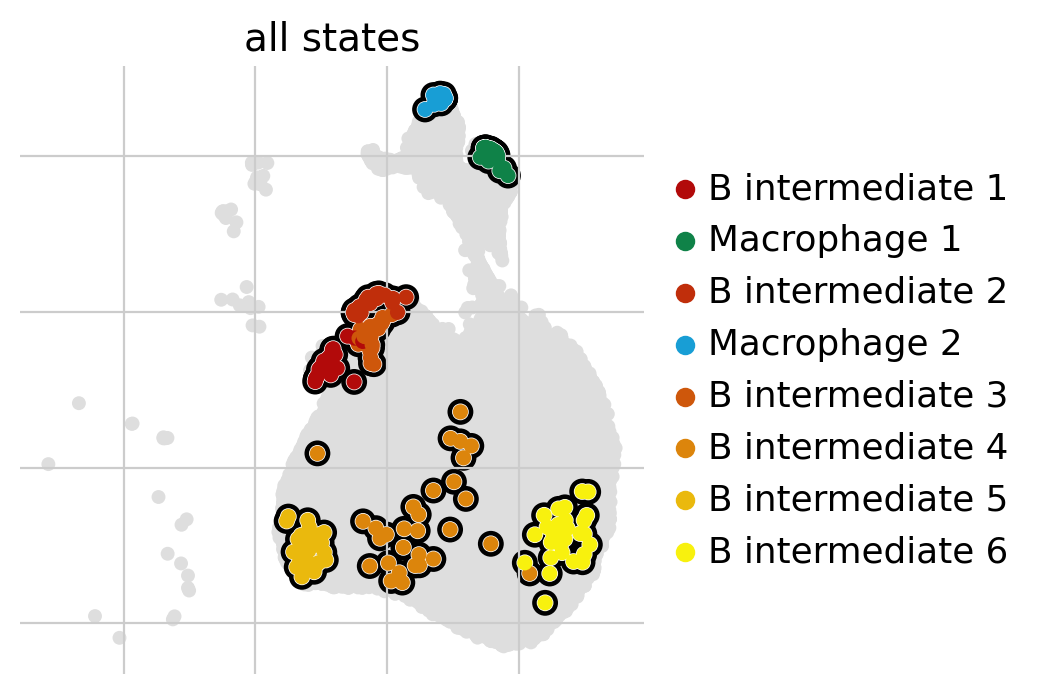

In [36]:
g2.compute_macrostates(n_states=8, cluster_key="final_annot")
g2.plot_macrostates(which="all", legend_loc="right", s=100)